In [2]:
### WIP



In [3]:
# https://github.com/SeldonIO/alibi-detect#drift-detection

In [4]:
#pip  install alibi-detect --user
#pip  install tensorflow

#pip  install alibi
# !pip install catboost
# !pip install shap
# !pip install xgboost


In [5]:


import alibi
import matplotlib.pyplot as plt

from alibi_detect.cd import TabularDrift
from alibi_detect.utils.saving import save_detector, load_detector


import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt    
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from catboost import Pool

import shap

import warnings

In [6]:
data = pd.read_csv('data.csv')

# cd = MMDDrift(x_ref, backend='tensorflow', p_val=.05)
# preds = cd.predict(x)

In [7]:
data.head(5)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,148,Male,0,No,No,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,45.65,45.65,Yes
1,463,Male,0,Yes,Yes,4,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,101.15,385.90,Yes
2,471,Female,1,No,No,17,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.65,330.60,No
3,496,Male,0,No,No,22,No,No phone service,DSL,No,...,Yes,No,No,Yes,One year,Yes,Bank transfer (automatic),43.75,903.60,Yes
4,833,Female,0,Yes,Yes,70,Yes,No,DSL,Yes,...,Yes,Yes,No,Yes,One year,No,Credit card (automatic),74.10,5222.30,No


In [8]:
# do all data massaging
# Convert binary variable into numeric so plotting is easier. We need to later take mean
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

data.replace(" ", np.nan, inplace=True)

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

mean = data['TotalCharges'].mean()
data.fillna(mean, inplace=True)

import category_encoders as ce
import joblib

names = ['gender', 'Partner', 'Dependents', 'PhoneService', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
# for column in names:
#     labelencoder(column)
data_enc = data
data_enc = data_enc.drop(['Churn', 'customerID'], axis=1)
enc = ce.ordinal.OrdinalEncoder(cols=names)
enc.fit(data_enc)
labelled_set = enc.transform(data_enc)

names = ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod', 'OnlineSecurity', 'OnlineBackup',
         'DeviceProtection', 'TechSupport']

ohe = ce.OneHotEncoder(cols=names)
data_ohe = data
data_ohe = data_ohe.drop(['Churn', 'customerID'], axis=1)
ohe.fit(data_ohe)
final_set = ohe.transform(labelled_set)
columns_name =final_set.columns
final_set.head(5)





is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_1,MultipleLines_2,MultipleLines_3,InternetService_1,...,Contract_1,Contract_2,Contract_3,PaperlessBilling,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,MonthlyCharges,TotalCharges
0,1,0,1,1,1,1,1,0,0,1,...,1,0,0,1,1,0,0,0,45.65,45.65
1,1,0,2,2,4,1,0,1,0,0,...,1,0,0,2,1,0,0,0,101.15,385.90
2,2,1,1,1,17,1,1,0,0,0,...,0,1,0,2,0,1,0,0,20.65,330.60
3,1,0,1,1,22,2,0,0,1,1,...,0,1,0,1,0,0,1,0,43.75,903.60
4,2,0,2,2,70,1,1,0,0,1,...,0,1,0,2,0,0,0,1,74.10,5222.30


In [9]:
from sklearn.preprocessing import QuantileTransformer

qt_t= QuantileTransformer(n_quantiles=100, output_distribution= 'normal',random_state=0).fit(final_set.values)
final_set  = qt_t.transform(final_set.values)
final_set[:5,:]
final_set = pd.DataFrame(final_set,columns=columns_name )
final_set.head(5)





,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_1,MultipleLines_2,MultipleLines_3,InternetService_1,...,Contract_1,Contract_2,Contract_3,PaperlessBilling,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,MonthlyCharges,TotalCharges
0,-5.199338,-5.199338,-5.199338,-5.199338,-1.690622,-5.199338,5.199338,-5.199338,-5.199338,5.199338,...,5.199338,-5.199338,-5.199338,-5.199338,5.199338,-5.199338,-5.199338,-5.199338,-0.534565,-1.725160
1,-5.199338,-5.199338,5.199338,5.199338,-0.987837,-5.199338,-5.199338,5.199338,-5.199338,-5.199338,...,5.199338,-5.199338,-5.199338,5.199338,5.199338,-5.199338,-5.199338,-5.199338,1.222618,-0.690587
2,5.199338,5.199338,-5.199338,-5.199338,-0.335333,-5.199338,5.199338,-5.199338,-5.199338,-5.199338,...,-5.199338,5.199338,-5.199338,5.199338,-5.199338,5.199338,-5.199338,-5.199338,-1.029957,-0.753107
3,-5.199338,-5.199338,-5.199338,-5.199338,-0.191052,5.199338,-5.199338,-5.199338,5.199338,5.199338,...,-5.199338,5.199338,-5.199338,-5.199338,-5.199338,-5.199338,5.199338,-5.199338,-0.606415,-0.281486
4,5.199338,-5.199338,5.199338,5.199338,1.366707,-5.199338,5.199338,-5.199338,-5.199338,5.199338,...,-5.199338,5.199338,-5.199338,5.199338,-5.199338,-5.199338,-5.199338,5.199338,0.087163,1.045390


In [ ]:
# from sklearn.decomposition import IncrementalPCA
# transformer = IncrementalPCA(n_components=7, batch_size=200)
# # either partially fit on smaller batches of data
# transformer.partial_fit(X[:100, :])

In [10]:
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,148,Male,0,No,No,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,45.65,45.65,1
1,463,Male,0,Yes,Yes,4,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,101.15,385.90,1
2,471,Female,1,No,No,17,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.65,330.60,0
3,496,Male,0,No,No,22,No,No phone service,DSL,No,...,Yes,No,No,Yes,One year,Yes,Bank transfer (automatic),43.75,903.60,1
4,833,Female,0,Yes,Yes,70,Yes,No,DSL,Yes,...,Yes,Yes,No,Yes,One year,No,Credit card (automatic),74.10,5222.30,0


In [11]:

from sklearn.model_selection import train_test_split
labels = data['Churn']
X_train, X_test, Y_train, Y_test = train_test_split(final_set, labels, test_size=0.3)
print ('Training Data Shape',X_train.shape, Y_train.shape)
print ('Testing Data Shape',X_test.shape, Y_test.shape)

Y = data['Churn']
X = final_set

X_test_1, X_test_2, Y_test_1, Y_test_2 = train_test_split(X_test, Y_test, test_size=0.5)



Training Data Shape (4930, 36) (4930,)
Testing Data Shape (2113, 36) (2113,)


In [12]:
Y = data['Churn']
Y

0       1
1       1
2       0
3       1
4       0
       ..
7038    1
7039    1
7040    0
7041    0
7042    0
Name: Churn, Length: 7043, dtype: int64

In [13]:
print(X_train.shape)


print(X_test_1.shape)
print(X_test_2.shape)

(4930, 36)
(1056, 36)
(1057, 36)


## <a id="45">Catboost</a> 
We utilise the catboost to figure out which features are more important, we can utilise the other techniques to find the most important features such as random forest. On the other hand, we can take benefits of the dimention reduction models to transfer and find the most effective features.

In [14]:
from catboost import Pool
from catboost import CatBoostClassifier
import seaborn as sns
# categorical_ft = [x for x in X.columns if x not in num_features]
# print(categorical_ft)



In [15]:
cat_model = CatBoostClassifier (random_state = 42, eval_metric = 'AUC', verbose = 0)
#cat_model.get_params()

cat_param = {'n_estimators':100}
cat_model.set_params(**cat_param) 

In [16]:
Y_train

1074    1
5409    0
6102    1
6751    0
6625    1
       ..
6158    0
4506    0
4154    0
3080    1
3314    0
Name: Churn, Length: 4930, dtype: int64

In [17]:
cat_model.fit(X_train, Y_train, eval_set = [(X_test,Y_test)])

#xgb_model.fit(X_train, Y_train, early_stopping_rounds = 100, eval_set = [(X_test,Y_test)])
#cat_model.fit(X_train, Y_train)

pred_cat = cat_model.predict(X_test)

print("Test Accuracy: ",metrics.accuracy_score(Y_test, pred_cat))

Test Accuracy:  0.812588736393753


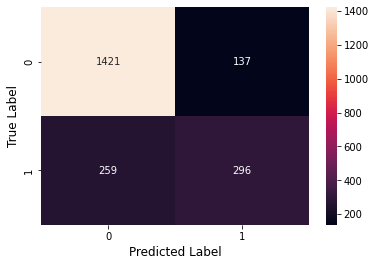

In [18]:
cat_confusion_matrix = metrics.confusion_matrix(Y_test, pred_cat)
sns.heatmap(cat_confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [19]:
print(metrics.classification_report(Y_test, pred_cat, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1558
           1       0.68      0.53      0.60       555

    accuracy                           0.81      2113
   macro avg       0.76      0.72      0.74      2113
weighted avg       0.80      0.81      0.80      2113



ROC_AUC:  0.8591055754085279


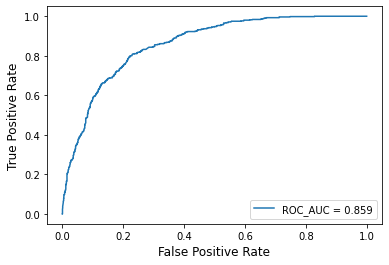

In [20]:
cat_pred_proba = cat_model.predict_proba(X_test)[:,1]

cat_roc_auc = metrics.roc_auc_score(Y_test, cat_pred_proba)
print('ROC_AUC: ', cat_roc_auc)

cat_fpr, cat_tpr, thresholds = metrics.roc_curve(Y_test, cat_pred_proba)

plt.plot(cat_fpr,cat_tpr, label = 'ROC_AUC = %0.3f' % cat_roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

## <a id="46">Feature Importance and SHAP Plot</a>

Let’s see what features have more importance for the Catboost’s predictions.

In [29]:
pool = Pool(X_train, Y_train)

Feature_importance = pd.DataFrame({'feature_importance': cat_model.get_feature_importance(pool), 
                      'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

Feature_importance

,feature_importance,feature_names
4,18.974523,tenure
10,12.421938,InternetService_2
26,10.711388,Contract_1
28,8.658785,Contract_3
35,7.697348,TotalCharges
30,5.668721,PaymentMethod_1
12,4.901954,OnlineSecurity_1
25,4.383029,StreamingMovies
29,3.866562,PaperlessBilling
24,3.108838,StreamingTV


In [22]:
Feature_importance.shape

(36, 2)

In [32]:
Feature_importance.feature_names[1]

'SeniorCitizen'

In [36]:
selected_feature_list = []
for i in range(Feature_importance.shape[0]):
    if Feature_importance.feature_importance[i]>2:
        selected_feature_list.append(Feature_importance.feature_names[i])  
# for per, fname in Feature_importance:
#     if per>2.5:
#          selected_feature_list.append(fname)               

In [37]:
selected_feature_list

['tenure',
 'InternetService_1',
 'InternetService_2',
 'OnlineSecurity_1',
 'StreamingTV',
 'StreamingMovies',
 'Contract_1',
 'Contract_3',
 'PaperlessBilling',
 'PaymentMethod_1',
 'PaymentMethod_2',
 'MonthlyCharges',
 'TotalCharges']

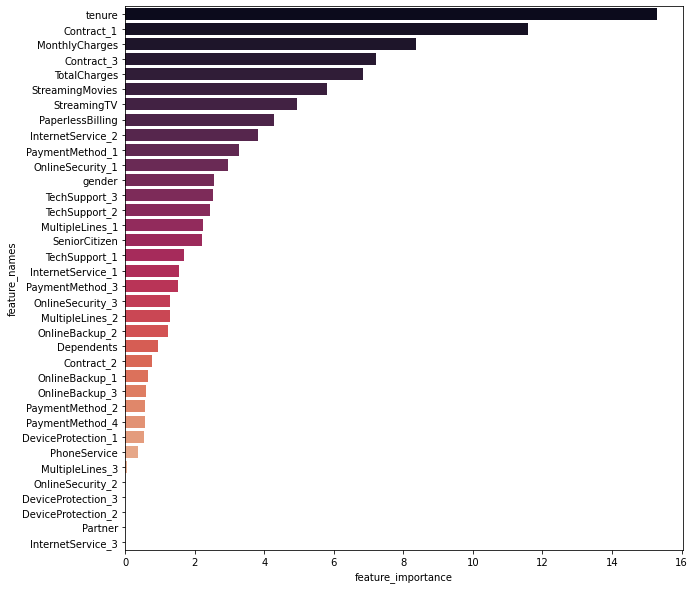

In [18]:
plt.figure(figsize=(10,10))

sns.barplot(x=Feature_importance['feature_importance'], y=Feature_importance['feature_names'], palette = 'rocket')

plt.show()

Select the most importat features to generate all possible combination of the features. 
Due to large range of numeric features we need to quantise the features values. 

In [40]:

data_enc = final_set[selected_feature_list]
data_enc.columns
data_enc.nunique()
features = []
features_name = selected_feature_list
for col in data_enc:
#   print(df[col].unique())
    if len (data_enc[col].unique())>10:
        min_f = min(data_enc[col].unique())
        max_f = max(data_enc[col].unique())
        new_range = np.linspace(min_f, max_f, 10)
        features.append(new_range)
#         features_name.append(col)
    else:
        
        features.append(data_enc[col].unique())
#         features_name.append(col)
        
print (features)
print (features_name)
# print (selected_feature_list)


[array([-5.19933758, -4.04392923, -2.88852088, -1.73311253, -0.57770418,
        0.57770418,  1.73311253,  2.88852088,  4.04392923,  5.19933758]), array([ 5.19933758, -5.19933758]), array([-5.19933758,  5.19933758]), array([ 5.19933758, -5.19933758]), array([-5.19933758,  0.22988412,  5.19933758]), array([-5.19933758,  0.22988412,  5.19933758]), array([ 5.19933758, -5.19933758]), array([-5.19933758,  5.19933758]), array([-5.19933758,  5.19933758]), array([ 5.19933758, -5.19933758]), array([-5.19933758,  5.19933758]), array([-5.19933758, -4.04392923, -2.88852088, -1.73311253, -0.57770418,
        0.57770418,  1.73311253,  2.88852088,  4.04392923,  5.19933758]), array([-5.19933758, -4.04392923, -2.88852088, -1.73311253, -0.57770418,
        0.57770418,  1.73311253,  2.88852088,  4.04392923,  5.19933758])]
['tenure', 'InternetService_1', 'InternetService_2', 'OnlineSecurity_1', 'StreamingTV', 'StreamingMovies', 'Contract_1', 'Contract_3', 'PaperlessBilling', 'PaymentMethod_1', 'PaymentMet

generate all possible combination

In [41]:
import itertools
combination = list(itertools.product(*features))

Filter the dataset based on the most important features

In [42]:
data_enc1 = data_enc[features_name]



Convert the nominal value to the numeric one

In [44]:
# yes_or_no_map = {'No': 0, 'Yes': 1} #seniorcitizen, partner, dependents, phoneservice, paperlessbilling
# multiplelines_map = {'No phone service': -1, 'No': 0, 'Yes': 1}
# add_netservices_map = {'No internet service': -1, 'No': 0, 'Yes': 1} #onlinesecurity, onlinebackup, deviceprotection,techsupport,streaming services
# contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
# paymentmethod_map = {'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3}




# # data_enc1['SeniorCitizen'] = data_enc1['SeniorCitizen'].map(yes_or_no_map).stype('int')
# data_enc1['MultipleLines'] = data_enc1['MultipleLines'].map(multiplelines_map).astype('int')
# data_enc1['OnlineSecurity'] = data_enc1['OnlineSecurity'].map(add_netservices_map).astype('int')
# data_enc1['TechSupport'] = data_enc1['TechSupport'].map(add_netservices_map).astype('int')
# data_enc1['Contract'] = data_enc1['Contract'].map(contract_map).astype('int')
# data_enc1['PaperlessBilling'] = data_enc1['PaperlessBilling'].map(yes_or_no_map).astype('int')
# data_enc1['PaymentMethod'] = data_enc1['PaymentMethod'].map(paymentmethod_map).astype('int')

Scale the float features with the large range to 20 different scale via closest value.

In [45]:

data_enc2 = data_enc1.copy()
for index, row in data_enc1.iterrows():

    absolute_difference_function_tc = lambda list_value : abs(list_value - data_enc1.loc[index,'TotalCharges'])
    closest_value_tc = min(features[9], key=absolute_difference_function_tc)
    data_enc2.loc[index, 'TotalCharges']= closest_value_tc

    absolute_difference_function_mc = lambda list_value : abs(list_value - data_enc1.loc[index,'MonthlyCharges'])
    closest_value_mc = min(features[8], key=absolute_difference_function_mc)
    data_enc2.loc[index, 'MonthlyCharges']= closest_value_mc

    absolute_difference_function_t = lambda list_value : abs(list_value - data_enc1.loc[index,'tenure'])
    closest_value_t = min(features[1], key=absolute_difference_function_t)
    data_enc2.loc[index, 'tenure']= closest_value_t

    

Apply K-means on original data to cluster them to several groups.
We need to do this to reduce the amount of Comparison by the all possible combinations.


In [47]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=150, random_state=0).fit(data_enc2)
kcenter = kmeans.cluster_centers_




Train the KNN by feeding all center samples to it :).

In [48]:

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(kcenter)

NearestNeighbors(n_neighbors=1)

Then the next step could be one of these two different pathes:
    
    - feed all sample one by one and extract their  Corresponding ks test or p-value;
    
    - apply the Kmeans and then get the centers and finnaly get the corresponding P-value.
    
    

In [49]:

df_combination = pd.DataFrame (combination,columns=features_name)
df_combination['MultipleLines'] = df_combination['MultipleLines'].map(multiplelines_map).astype('int')
df_combination['OnlineSecurity'] = df_combination['OnlineSecurity'].map(add_netservices_map).astype('int')
df_combination['TechSupport'] = df_combination['TechSupport'].map(add_netservices_map).astype('int')
df_combination['Contract'] = df_combination['Contract'].map(contract_map).astype('int')
df_combination['PaperlessBilling'] = df_combination['PaperlessBilling'].map(yes_or_no_map).astype('int')
df_combination['PaymentMethod'] = df_combination['PaymentMethod'].map(paymentmethod_map).astype('int')
df_combination.sort_index(inplace =True)


KeyError: 'MultipleLines'

In [ ]:
# df_combination.shape
list_dist = []
for index, row in df_combination.iterrows(): 
    list_dist.append(neigh.kneighbors([df_combination.iloc[index].values]))

In [ ]:
kmeans_comb = KMeans(n_clusters=100, random_state=0).fit(df_combination)
kmeans_comb_center = kmeans_comb.cluster_centers_


In [ ]:
kmeans_comb_center

In [ ]:
# from alibi_detect.od import IForest
# od = IForest(threshold=0.05, n_estimators=500)

# od.fit(X_train.values)
X_train.shape
cd = TabularDrift(X_train.values, p_val=.05, categories_per_feature=categories_per_feature)

In [ ]:

# od_preds = od.predict(X_test, return_instance_score=True)
# print(od_preds)
#
#col #34 is the monthly bill amount
X_test_1['tenure']=40
X_test_1['MonthlyCharges']=40
X_test_1['TotalCharges']=7000

input_with_insane_monthly_charges = X_test_1.iloc[2]
# input_with_insane_monthly_charges.values[34] = 22975.0
# input_with_insane_monthly_charges.values[35] = 25000.0
print(input_with_insane_monthly_charges.values.reshape(1,19))

cd_preds = cd.predict(input_with_insane_monthly_charges.values.reshape(1,19))
print(cd_preds)

# from alibi_detect.cd import MMDDrift

# cd1 = MMDDrift(X_train.values, backend='tensorflow', p_val=.05)
# preds = cd1.predict(input_with_insane_monthly_charges.values.reshape(1,19))
# print(preds)
